#  Классификация изображений с помощью сверточных нейронных сетей

In [ ]:
import os
from tqdm import tqdm
import random
import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy, F1Score

import matplotlib.pyplot as plt
from PIL import Image


ModuleNotFoundError: No module named 'torchmetrics'

<p class="task" id="1"></p>

1\. Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.


In [ ]:
class CatBreedsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = ["American Shorthair", "Persian", "Russian Blue", "Tiger"]

        # {"American Shorthair": 0, "Persian": 1, "Russian Blue": 2, "Tiger": 3}
        self.label_to_idx = {label: idx for idx, label in enumerate(self.classes)}
        # {0: "American Shorthair", 1: "Persian", 2: "Russian Blue", 3: "Tiger"}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

        for label in self.classes:
            class_path = os.path.join(root_dir, label)
            for img_file in os.listdir(class_path):
                if img_file.endswith('.jpg'):
                    self.image_paths.append(os.path.join(class_path, img_file))
                    self.labels.append(self.label_to_idx[label])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
initial_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

dataset = CatBreedsDataset('cat_breeds_4', transform=initial_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

def mean_std(dataloader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in dataloader:
        for i in range(3):
            mean[i] += images[:, i, :, :].mean()
            std[i] += images[:, i, :, :].std()
    mean /= len(dataloader)
    std /= len(dataloader)
    return mean, std


In [ ]:
mean, std = mean_std(dataloader)

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

final_dataset = CatBreedsDataset('cat_breeds_4', transform=transform)

train_size = int(0.8 * len(final_dataset))
test_size = len(final_dataset) - train_size
train_dataset, test_dataset = random_split(final_dataset, [train_size, test_size], torch.Generator().manual_seed(42))

In [ ]:
print(f'Количество изображений: {len(final_dataset)}')
print(f'Размер одной картинки: {final_dataset[0][0].size()}')
print(f'Количество уникальных классов: {len(final_dataset.label_to_idx)}')
print(f'Размер обучающей выборки: {len(train_dataset)}')
print(f'Размер тестовой выборки: {len(test_dataset)}')

Количество изображений: 4000
Размер одной картинки: torch.Size([3, 300, 300])
Количество уникальных классов: 4
Размер обучающей выборки: 3200
Размер тестовой выборки: 800


<p class="task" id="2"></p>

2\. Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.   


In [ ]:
class Model_1(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.2):
        super(Model_1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device='cuda'):
    model.to(device)
    model.train()

    train_accuracy_metric = Accuracy(task='multiclass', num_classes=4).to(device)
    test_accuracy_metric = Accuracy(task='multiclass', num_classes=4).to(device)
    train_f1_metric = F1Score(task='multiclass', num_classes=4, average='weighted').to(device)
    test_f1_metric = F1Score(task='multiclass', num_classes=4, average='weighted').to(device)

    # списки для построение графиков
    train_loss_list = []
    train_accuracy_list = []
    train_f1_list = []
    test_loss_list = []
    test_accuracy_list = []
    test_f1_list = []

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0

        # Тренировка на обучающем множестве
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() # суммируем ошибку
            train_accuracy_metric.update(outputs, labels)
            train_f1_metric.update(outputs, labels)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = train_accuracy_metric.compute().item() * 100
        epoch_f1 = train_f1_metric.compute().item()

        # добавляем в списки
        train_loss_list.append(epoch_loss)
        train_accuracy_list.append(epoch_accuracy)
        train_f1_list.append(epoch_f1)

        # Оценка на тестовом множестве
        epoch_test_loss, epoch_test_accuracy, epoch_test_f1 = evaluate_model(model, test_loader, criterion, device)

        test_loss_list.append(epoch_test_loss)
        test_accuracy_list.append(epoch_test_accuracy)
        test_f1_list.append(epoch_test_f1)
        model.train() # Вернуться в режим тренировки

        # Очистка состояния метрик после каждой эпохи
        train_accuracy_metric.reset()
        train_f1_metric.reset()
        test_accuracy_metric.reset()
        test_f1_metric.reset()

        print(f'Epoch [{epoch+1}/{num_epochs}]:\n'
            f'  Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Train F1 Score: {epoch_f1:.2f}\n'
            f'  Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%, Test F1 Score: {epoch_test_f1:.2f}')
    return train_loss_list, train_accuracy_list, train_f1_list, test_loss_list, test_accuracy_list, test_f1_list


def evaluate_model(model, test_loader, criterion, device='cuda'):
    model.to(device)
    model.eval()
    accuracy_metric = Accuracy(task='multiclass', num_classes=4).to(device)
    f1_metric = F1Score(task='multiclass', num_classes=4, average='weighted').to(device)

    running_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            accuracy_metric.update(outputs, labels)
            f1_metric.update(outputs, labels)

    avg_loss = running_loss / len(test_loader)
    avg_accuracy = accuracy_metric.compute().item() * 100
    avg_f1 = f1_metric.compute().item()

    return avg_loss, avg_accuracy, avg_f1


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Размер входного изображения 3 * 300 * 300 = 270000
input_size = 3 * 300 * 300
hidden_size1 = 256  # Размерность первого скрытого слоя
hidden_size2 = 128  # Размерность второго скрытого слоя
num_classes = len(train_dataset.dataset.classes)

# Создание модели
model = Model_1(input_size, hidden_size1, hidden_size2, num_classes)
print(f'Количество параметров модели: {sum(p.numel() for p in model.parameters())}')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# Обучение модели
num_epochs = 20
train_loss_list, train_accuracy_list, train_f1_list, test_loss_list, test_accuracy_list, test_f1_list  = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs)

Количество параметров модели: 69153668


  5%|▌         | 1/20 [00:17<05:28, 17.27s/it]

Epoch [1/20]:
  Train Loss: 62.4931, Train Accuracy: 28.81%, Train F1 Score: 0.28
  Test Loss: 1.5064, Test Accuracy: 26.75%, Test F1 Score: 0.18


 10%|█         | 2/20 [00:33<05:02, 16.79s/it]

Epoch [2/20]:
  Train Loss: 1.7203, Train Accuracy: 30.53%, Train F1 Score: 0.26
  Test Loss: 1.3740, Test Accuracy: 28.75%, Test F1 Score: 0.18


 15%|█▌        | 3/20 [00:50<04:45, 16.77s/it]

Epoch [3/20]:
  Train Loss: 1.4752, Train Accuracy: 29.09%, Train F1 Score: 0.23
  Test Loss: 1.3736, Test Accuracy: 29.00%, Test F1 Score: 0.19


 20%|██        | 4/20 [01:07<04:30, 16.93s/it]

Epoch [4/20]:
  Train Loss: 1.4336, Train Accuracy: 31.22%, Train F1 Score: 0.24
  Test Loss: 1.3477, Test Accuracy: 31.25%, Test F1 Score: 0.21


 25%|██▌       | 5/20 [01:25<04:16, 17.11s/it]

Epoch [5/20]:
  Train Loss: 1.4016, Train Accuracy: 31.03%, Train F1 Score: 0.24
  Test Loss: 1.3391, Test Accuracy: 31.25%, Test F1 Score: 0.21


 30%|███       | 6/20 [01:42<04:02, 17.35s/it]

Epoch [6/20]:
  Train Loss: 1.3759, Train Accuracy: 31.97%, Train F1 Score: 0.24
  Test Loss: 1.3460, Test Accuracy: 30.63%, Test F1 Score: 0.20


 35%|███▌      | 7/20 [01:59<03:42, 17.09s/it]

Epoch [7/20]:
  Train Loss: 1.3578, Train Accuracy: 31.91%, Train F1 Score: 0.24
  Test Loss: 1.3504, Test Accuracy: 30.38%, Test F1 Score: 0.22


 40%|████      | 8/20 [02:16<03:23, 16.93s/it]

Epoch [8/20]:
  Train Loss: 1.3577, Train Accuracy: 32.28%, Train F1 Score: 0.25
  Test Loss: 1.3367, Test Accuracy: 31.50%, Test F1 Score: 0.21


 45%|████▌     | 9/20 [02:33<03:06, 16.95s/it]

Epoch [9/20]:
  Train Loss: 1.3311, Train Accuracy: 32.59%, Train F1 Score: 0.25
  Test Loss: 1.3484, Test Accuracy: 29.25%, Test F1 Score: 0.21


 50%|█████     | 10/20 [02:50<02:51, 17.14s/it]

Epoch [10/20]:
  Train Loss: 1.3491, Train Accuracy: 32.37%, Train F1 Score: 0.25
  Test Loss: 1.3361, Test Accuracy: 30.88%, Test F1 Score: 0.21


 55%|█████▌    | 11/20 [03:07<02:34, 17.19s/it]

Epoch [11/20]:
  Train Loss: 1.3565, Train Accuracy: 32.41%, Train F1 Score: 0.30
  Test Loss: 1.3357, Test Accuracy: 32.12%, Test F1 Score: 0.23


 60%|██████    | 12/20 [03:24<02:17, 17.16s/it]

Epoch [12/20]:
  Train Loss: 1.3466, Train Accuracy: 34.16%, Train F1 Score: 0.28
  Test Loss: 1.3410, Test Accuracy: 31.37%, Test F1 Score: 0.22


 65%|██████▌   | 13/20 [03:42<02:00, 17.15s/it]

Epoch [13/20]:
  Train Loss: 1.3311, Train Accuracy: 33.53%, Train F1 Score: 0.26
  Test Loss: 1.3471, Test Accuracy: 30.38%, Test F1 Score: 0.20


 70%|███████   | 14/20 [03:59<01:42, 17.15s/it]

Epoch [14/20]:
  Train Loss: 1.3280, Train Accuracy: 33.66%, Train F1 Score: 0.26
  Test Loss: 1.3563, Test Accuracy: 32.62%, Test F1 Score: 0.23


 75%|███████▌  | 15/20 [04:16<01:26, 17.27s/it]

Epoch [15/20]:
  Train Loss: 1.3490, Train Accuracy: 33.75%, Train F1 Score: 0.26
  Test Loss: 1.3377, Test Accuracy: 31.87%, Test F1 Score: 0.23


 80%|████████  | 16/20 [04:33<01:08, 17.13s/it]

Epoch [16/20]:
  Train Loss: 1.3378, Train Accuracy: 34.13%, Train F1 Score: 0.27
  Test Loss: 1.3281, Test Accuracy: 34.13%, Test F1 Score: 0.25


 85%|████████▌ | 17/20 [04:50<00:50, 16.92s/it]

Epoch [17/20]:
  Train Loss: 1.3288, Train Accuracy: 34.41%, Train F1 Score: 0.26
  Test Loss: 1.3562, Test Accuracy: 28.50%, Test F1 Score: 0.18


 90%|█████████ | 18/20 [05:07<00:33, 16.95s/it]

Epoch [18/20]:
  Train Loss: 1.3446, Train Accuracy: 34.13%, Train F1 Score: 0.26
  Test Loss: 1.3581, Test Accuracy: 31.13%, Test F1 Score: 0.21


 95%|█████████▌| 19/20 [05:23<00:16, 16.85s/it]

Epoch [19/20]:
  Train Loss: 1.3135, Train Accuracy: 34.06%, Train F1 Score: 0.26
  Test Loss: 1.3511, Test Accuracy: 31.00%, Test F1 Score: 0.21


100%|██████████| 20/20 [05:40<00:00, 17.01s/it]

Epoch [20/20]:
  Train Loss: 1.3435, Train Accuracy: 33.94%, Train F1 Score: 0.26
  Test Loss: 1.3515, Test Accuracy: 30.88%, Test F1 Score: 0.21


In [ ]:
# Оценка модели на тестовом множестве
_, test_accuracy, test_f1 = evaluate_model(model, test_loader, criterion)

In [ ]:
print(f'accuracy на обучающем множестве: {train_accuracy_list[-1]:.2f}%')
print(f'F1 score на обучающем множестве: {train_f1_list[-1]:.2f}%')
print(f'accuracy на тестовом множестве: {test_accuracy:.2f}%')
print(f'F1 score на тестовом множестве: {test_f1:.2f}%')

accuracy на обучающем множестве: 33.94%
F1 score на обучающем множестве: 0.26%
accuracy на тестовом множестве: 30.88%
F1 score на тестовом множестве: 0.21%


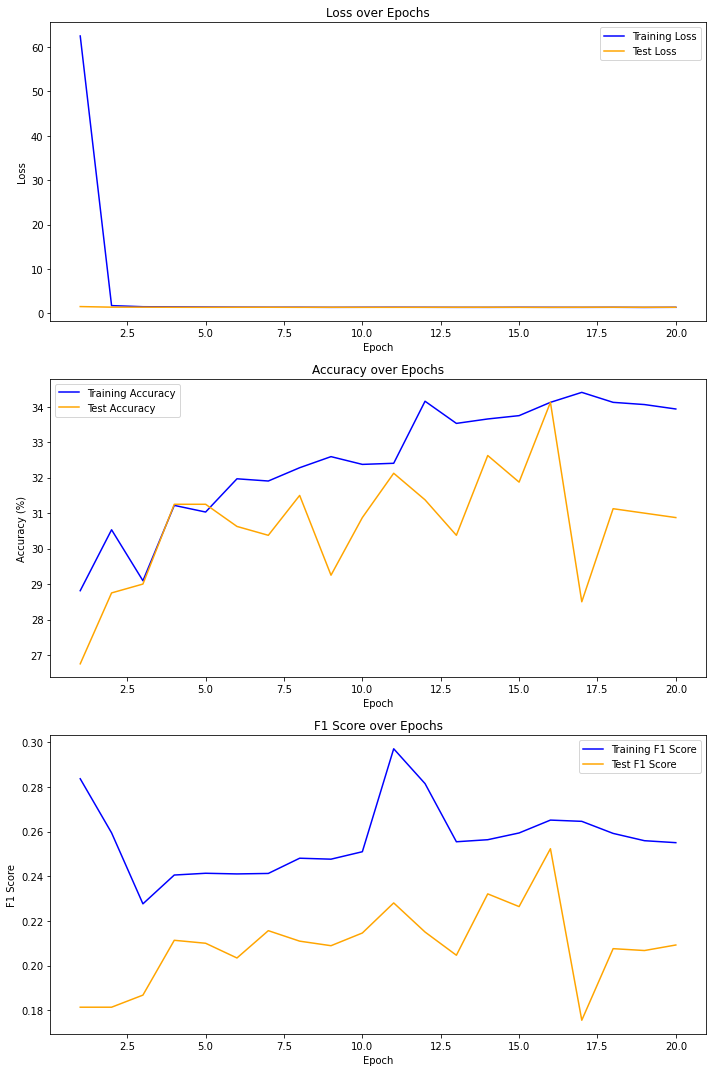

In [ ]:
def plot_metric(train_data, test_data, metric_name, num_epochs, subplot_index, title, ylabel):
    plt.subplot(3, 1, subplot_index)
    plt.plot(range(1, num_epochs + 1), train_data, label='Training ' + metric_name, color='blue')
    plt.plot(range(1, num_epochs + 1), test_data, label='Test ' + metric_name, color='orange')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()

# Построение графиков
plt.figure(figsize=(10, 15))

# Графики функции потерь
plot_metric(train_loss_list, test_loss_list, 'Loss', num_epochs, 1, 'Loss over Epochs', 'Loss')

# Графики точности
plot_metric(train_accuracy_list, test_accuracy_list, 'Accuracy', num_epochs, 2, 'Accuracy over Epochs', 'Accuracy (%)')

# Графики F1 Score
plot_metric(train_f1_list, test_f1_list, 'F1 Score', num_epochs, 3, 'F1 Score over Epochs', 'F1 Score')

plt.tight_layout()
plt.show()

In [ ]:
class Model_2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes, dropout_rate=0.2):
        super(Model_2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Применение Dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Применение Dropout
        x = self.relu(self.fc3(x))  # Применяем ReLU перед выходным слоем
        x = self.fc4(x)  # Выходной слой без активации
        return x

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Размер входного изображения 3 * 300 * 300 = 270000
input_size = 3 * 300 * 300
hidden_size1 = 256  # Размерность первого скрытого слоя
hidden_size2 = 128  # Размерность второго скрытого слоя
hidden_size3 = 64
num_classes = len(train_dataset.dataset.classes)

# Создание модели
model_2 = Model_2(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes)
print(f'Количество параметров модели: {sum(p.numel() for p in model_2.parameters())}')

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_2.parameters(), lr=0.0001, weight_decay=1e-4)

# Обучение модели
num_epochs = 10
train_loss_list_2, train_accuracy_list_2, train_f1_list_2, test_loss_list_2, test_accuracy_list_2, test_f1_list_2  = train_model(
    model_2, train_loader, test_loader, criterion, optimizer, num_epochs)

Количество параметров модели: 69161668


 10%|█         | 1/10 [00:17<02:35, 17.33s/it]

Epoch [1/10]:
  Train Loss: 1.5012, Train Accuracy: 32.59%, Train F1 Score: 0.32
  Test Loss: 1.3554, Test Accuracy: 41.62%, Test F1 Score: 0.42


 20%|██        | 2/10 [00:34<02:18, 17.33s/it]

Epoch [2/10]:
  Train Loss: 1.3928, Train Accuracy: 40.06%, Train F1 Score: 0.40
  Test Loss: 1.3237, Test Accuracy: 39.13%, Test F1 Score: 0.38


 30%|███       | 3/10 [00:51<02:00, 17.21s/it]

Epoch [3/10]:
  Train Loss: 1.2952, Train Accuracy: 43.03%, Train F1 Score: 0.43
  Test Loss: 1.3383, Test Accuracy: 36.00%, Test F1 Score: 0.36


 40%|████      | 4/10 [01:08<01:41, 16.86s/it]

Epoch [4/10]:
  Train Loss: 1.2306, Train Accuracy: 46.13%, Train F1 Score: 0.46
  Test Loss: 1.3846, Test Accuracy: 35.62%, Test F1 Score: 0.35


 50%|█████     | 5/10 [01:24<01:23, 16.74s/it]

Epoch [5/10]:
  Train Loss: 1.1773, Train Accuracy: 50.28%, Train F1 Score: 0.50
  Test Loss: 1.3482, Test Accuracy: 37.62%, Test F1 Score: 0.37


 60%|██████    | 6/10 [01:41<01:07, 16.82s/it]

Epoch [6/10]:
  Train Loss: 1.1326, Train Accuracy: 52.06%, Train F1 Score: 0.52
  Test Loss: 1.3587, Test Accuracy: 40.38%, Test F1 Score: 0.39


 70%|███████   | 7/10 [01:58<00:50, 16.89s/it]

Epoch [7/10]:
  Train Loss: 1.0768, Train Accuracy: 56.41%, Train F1 Score: 0.56
  Test Loss: 1.3732, Test Accuracy: 35.50%, Test F1 Score: 0.35


 80%|████████  | 8/10 [02:15<00:33, 16.86s/it]

Epoch [8/10]:
  Train Loss: 1.0342, Train Accuracy: 57.38%, Train F1 Score: 0.57
  Test Loss: 1.3647, Test Accuracy: 37.87%, Test F1 Score: 0.38


 90%|█████████ | 9/10 [02:31<00:16, 16.78s/it]

Epoch [9/10]:
  Train Loss: 0.9817, Train Accuracy: 59.56%, Train F1 Score: 0.60
  Test Loss: 1.4342, Test Accuracy: 39.38%, Test F1 Score: 0.39


100%|██████████| 10/10 [02:48<00:00, 16.88s/it]

Epoch [10/10]:
  Train Loss: 0.9459, Train Accuracy: 60.94%, Train F1 Score: 0.61
  Test Loss: 1.4513, Test Accuracy: 39.88%, Test F1 Score: 0.39


In [ ]:
# Оценка модели на тестовом множестве
_, test_accuracy_2, test_f1_2 = evaluate_model(model_2, test_loader, criterion)

In [ ]:
print(f'accuracy на обучающем множестве: {train_accuracy_list_2[-1]:.2f}%')
print(f'F1 score на обучающем множестве: {train_f1_list_2[-1]:.2f}')
print(f'accuracy на тестовом множестве: {test_accuracy_2:.2f}%')
print(f'F1 score на тестовом множестве: {test_f1_2:.2f}')

accuracy на обучающем множестве: 60.94%
F1 score на обучающем множестве: 0.61
accuracy на тестовом множестве: 39.88%
F1 score на тестовом множестве: 0.39


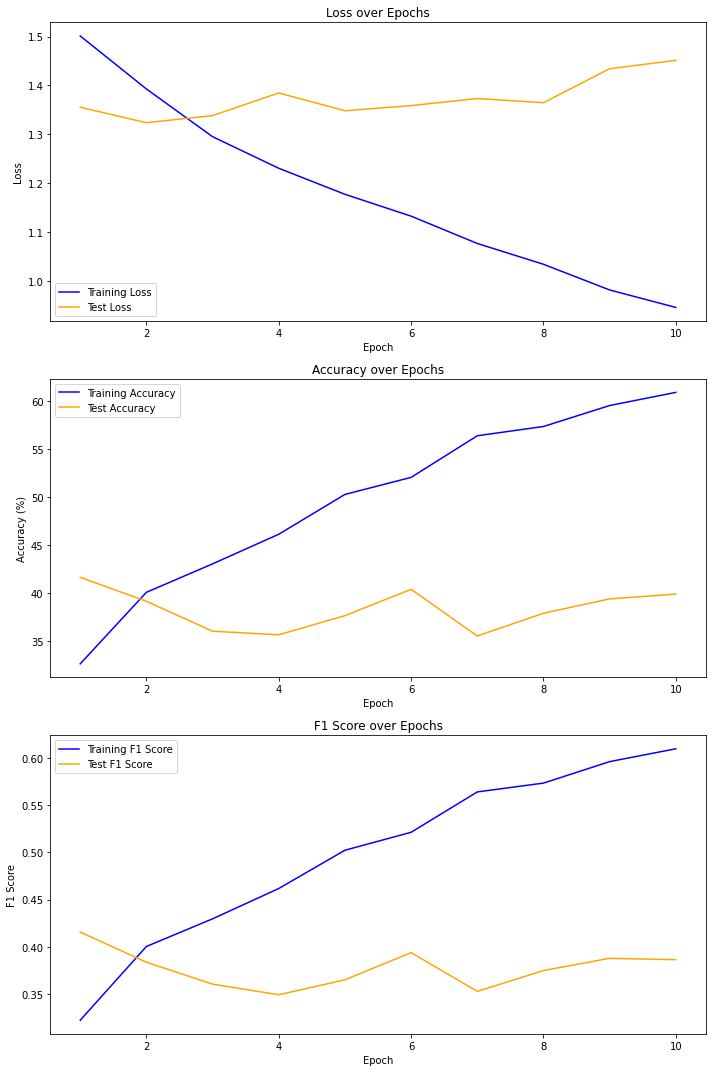

In [ ]:
def plot_metric(train_data, test_data, metric_name, num_epochs, subplot_index, title, ylabel):
    plt.subplot(3, 1, subplot_index)
    plt.plot(range(1, num_epochs + 1), train_data, label='Training ' + metric_name, color='blue')
    plt.plot(range(1, num_epochs + 1), test_data, label='Test ' + metric_name, color='orange')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()

# Построение графиков
plt.figure(figsize=(10, 15))

# Графики функции потерь
plot_metric(train_loss_list_2, test_loss_list_2, 'Loss', num_epochs, 1, 'Loss over Epochs', 'Loss')

# Графики точности
plot_metric(train_accuracy_list_2, test_accuracy_list_2, 'Accuracy', num_epochs, 2, 'Accuracy over Epochs', 'Accuracy (%)')

# Графики F1 Score
plot_metric(train_f1_list_2, test_f1_list_2, 'F1 Score', num_epochs, 3, 'F1 Score over Epochs', 'F1 Score')

plt.tight_layout()
plt.show()


<p class="task" id="3"></p>

3\. Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

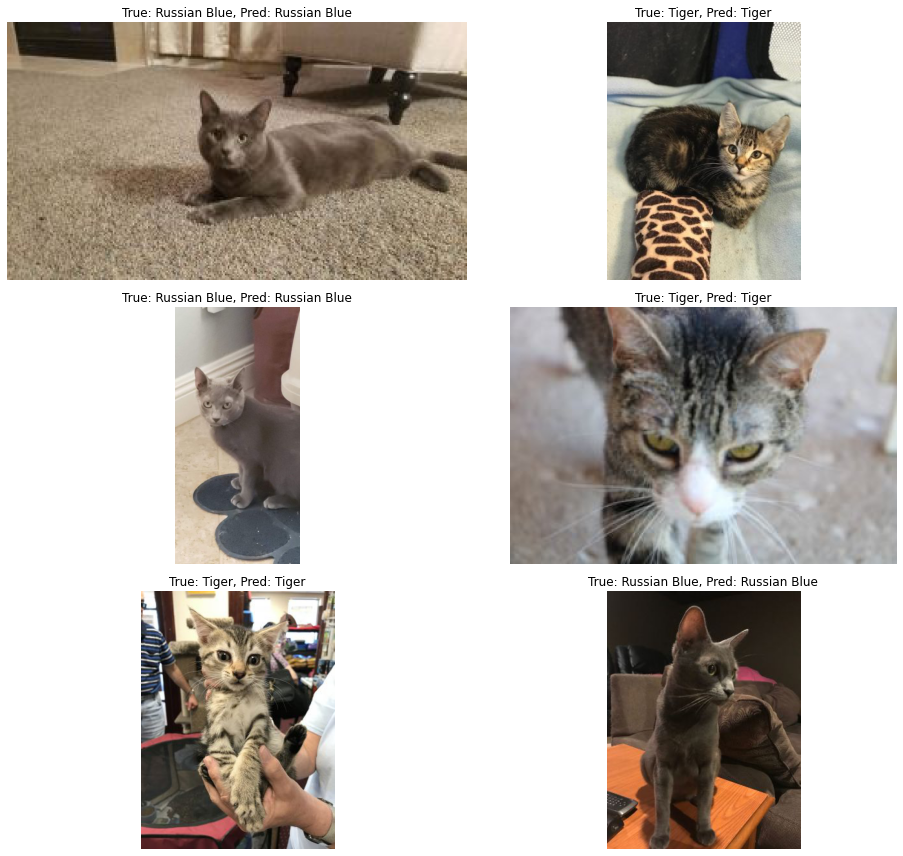

In [ ]:
def show_examples(model, dataset, temp_dataset, k=6):
    model.to('cpu')
    model.eval()  # Устанавливаем модель в режим оценки
    indices = random.sample(range(len(dataset)), k)  # Выбираем k случайных индексов
    images, true_labels = zip(*[dataset[i] for i in indices])  # Извлекаем изображения и истинные метки
    im, _ = zip(*[temp_dataset[i] for i in indices])

    images = torch.stack(images)  # Объединяем изображения в один тензор
    true_labels = torch.tensor(true_labels)  # Преобразуем истинные метки в тензор

    with torch.no_grad():  # Отключаем градиенты для оценки
        outputs = model(images)  # Получаем предсказания модели
        _, predicted_labels = torch.max(outputs, 1)  # Находим классы с максимальными логитами

    # Визуализация изображений
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()  # Упрощаем доступ к осям
    for i in range(k):
        ax = axes[i]
        ax.imshow(im[i].permute(1, 2, 0))  # Переводим в формат (H, W, C)
        ax.set_title(f'True: {dataset.idx_to_label[true_labels[i].item()]}, Pred: {dataset.idx_to_label[predicted_labels[i].item()]}')
        ax.axis('off')  # Отключаем оси

    plt.tight_layout()
    plt.show()

origin_cats = CatBreedsDataset('cat_breeds_4', transform=transforms.ToTensor())
show_examples(model, final_dataset, origin_cats, k=6)

In [ ]:
def show_examples_compare(model, final_dataset, origin_dataset, k=6):
    model.to('cpu')
    model.eval()  # Устанавливаем модель в режим оценки
    indices = random.sample(range(len(final_dataset)), k)  # Выбираем k случайных индексов
    images, true_labels = zip(*[final_dataset[i] for i in indices])  # Извлекаем изображения и истинные метки
    im, _ = zip(*[origin_dataset[i] for i in indices])

    images = torch.stack(images)  # Объединяем изображения в один тензор
    true_labels = torch.tensor(true_labels)  # Преобразуем истинные метки в тензор

    with torch.no_grad():  # Отключаем градиенты для оценки
        outputs = model(images)  # Получаем предсказания модели
        _, predicted_labels = torch.max(outputs, 1)  # Находим классы с максимальными логитами

    # Визуализация изображений
    fig, axes = plt.subplots(6, 2, figsize=(15, 12))
    axes = axes.flatten()  # Упрощаем доступ к осям
    for i in range(k):
        ax = axes[2*i]
        ax.imshow(im[i].permute(1, 2, 0))  # Переводим в формат (H, W, C)
        ax.set_title(f'True: {dataset.idx_to_label[true_labels[i].item()]}, Pred: {dataset.idx_to_label[predicted_labels[i].item()]}')
        ax.axis('off')  # Отключаем оси

        ax = axes[2*i+1]
        ax.imshow(images[i].permute(1, 2, 0))  # Переводим в формат (H, W, C)
        ax.set_title(f'True: {dataset.idx_to_label[true_labels[i].item()]}, Pred: {dataset.idx_to_label[predicted_labels[i].item()]}')
        ax.axis('off')  # Отключаем оси

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


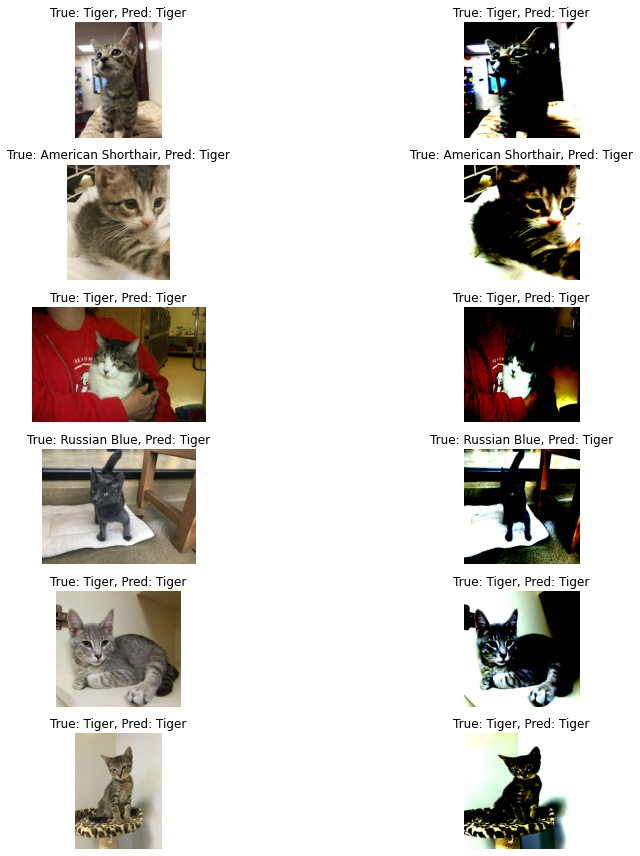

In [ ]:
origin_dataset = CatBreedsDataset('cat_breeds_4', transform=transforms.ToTensor())
train_size = int(0.8 * len(origin_dataset))
test_size = len(origin_dataset) - train_size
train_origin_dataset, test_origin_dataset = random_split(origin_dataset, [train_size, test_size], torch.Generator().manual_seed(42))

show_examples_compare(model, test_dataset.dataset, test_origin_dataset.dataset, k=6)

<p class="task" id="4"></p>

4\. Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.


In [ ]:
import torch.nn.functional as F


class Model_CNN_1(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2):
        super(Model_CNN_1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2)  # Первый свёрточный слой
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2)  # Второй свёрточный слой

        # Слой подвыборки
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)  # Max pooling слой

        # Полносвязные слои
        self.fc1 = nn.Linear(192 * 37 * 37, 256)  # Учитывая, что после обработки размерность уменьшается
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, num_classes)  # Выходной слой

        self.dropout = nn.Dropout(dropout_rate)  # Слой Dropout
        self.relu = nn.ReLU()

    def forward(self, x):
        # Прямой проход через свёрточные слои
        x = self.relu(self.conv1(x))  # Применяем первый свёрточный слой
        x = self.pool(x)               # Max pooling
        x = self.relu(self.conv2(x))  # Применяем второй свёрточный слой
        x = self.pool(x)               # Max pooling

        # Преобразуем данные в вектор
        x = x.view(x.size(0), -1)  # Преобразование в вектор

        # Прямой проход через полносвязные слои
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Выходной слой
        return x

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

num_classes = len(train_dataset.dataset.classes)

# Создание  модели
model = Model_CNN_1(num_classes=num_classes)
print(f'Количество параметров модели: {sum(p.numel() for p in model.parameters())}')

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Обучение модели
num_epochs = 10
train_loss_list, train_accuracy_list, train_f1_list, test_loss_list, test_accuracy_list, test_f1_list  = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs)

Количество параметров модели: 46100036


 10%|█         | 1/10 [00:22<03:18, 22.11s/it]

Epoch [1/10]:
  Train Loss: 1.5777, Train Accuracy: 30.69%, Train F1 Score: 0.30
  Test Loss: 1.2989, Test Accuracy: 35.00%, Test F1 Score: 0.31


 20%|██        | 2/10 [00:44<02:59, 22.45s/it]

Epoch [2/10]:
  Train Loss: 1.2713, Train Accuracy: 42.53%, Train F1 Score: 0.41
  Test Loss: 1.2609, Test Accuracy: 44.00%, Test F1 Score: 0.42


 30%|███       | 3/10 [01:08<02:39, 22.82s/it]

Epoch [3/10]:
  Train Loss: 1.1860, Train Accuracy: 49.19%, Train F1 Score: 0.49
  Test Loss: 1.2440, Test Accuracy: 43.63%, Test F1 Score: 0.42


 40%|████      | 4/10 [01:30<02:16, 22.80s/it]

Epoch [4/10]:
  Train Loss: 1.1102, Train Accuracy: 52.75%, Train F1 Score: 0.52
  Test Loss: 1.2092, Test Accuracy: 49.38%, Test F1 Score: 0.46


 50%|█████     | 5/10 [01:51<01:50, 22.14s/it]

Epoch [5/10]:
  Train Loss: 1.0217, Train Accuracy: 58.84%, Train F1 Score: 0.58
  Test Loss: 1.1986, Test Accuracy: 49.13%, Test F1 Score: 0.49


 60%|██████    | 6/10 [02:12<01:26, 21.71s/it]

Epoch [6/10]:
  Train Loss: 0.9659, Train Accuracy: 61.31%, Train F1 Score: 0.61
  Test Loss: 1.2153, Test Accuracy: 49.00%, Test F1 Score: 0.46


 70%|███████   | 7/10 [02:33<01:04, 21.41s/it]

Epoch [7/10]:
  Train Loss: 0.8888, Train Accuracy: 64.63%, Train F1 Score: 0.64
  Test Loss: 1.1919, Test Accuracy: 48.75%, Test F1 Score: 0.47


 80%|████████  | 8/10 [02:54<00:42, 21.25s/it]

Epoch [8/10]:
  Train Loss: 0.8284, Train Accuracy: 69.47%, Train F1 Score: 0.69
  Test Loss: 1.2018, Test Accuracy: 49.38%, Test F1 Score: 0.49


 90%|█████████ | 9/10 [03:14<00:21, 21.02s/it]

Epoch [9/10]:
  Train Loss: 0.7552, Train Accuracy: 72.78%, Train F1 Score: 0.73
  Test Loss: 1.2203, Test Accuracy: 48.88%, Test F1 Score: 0.48


100%|██████████| 10/10 [03:35<00:00, 21.54s/it]

Epoch [10/10]:
  Train Loss: 0.6978, Train Accuracy: 75.47%, Train F1 Score: 0.75
  Test Loss: 1.2119, Test Accuracy: 49.13%, Test F1 Score: 0.49


In [ ]:
# Оценка модели на тестовом множестве
_, test_accuracy, test_f1 = evaluate_model(model, test_loader, criterion)

In [ ]:
print(f'accuracy на обучающем множестве: {train_accuracy_list[-1]:.2f}%')
print(f'F1 score на обучающем множестве: {train_f1_list[-1]:.2f}')
print(f'accuracy на тестовом множестве: {test_accuracy:.2f}%')
print(f'F1 score на тестовом множестве: {test_f1:.2f}')

accuracy на обучающем множестве: 75.47%
F1 score на обучающем множестве: 0.75
accuracy на тестовом множестве: 49.13%
F1 score на тестовом множестве: 0.49


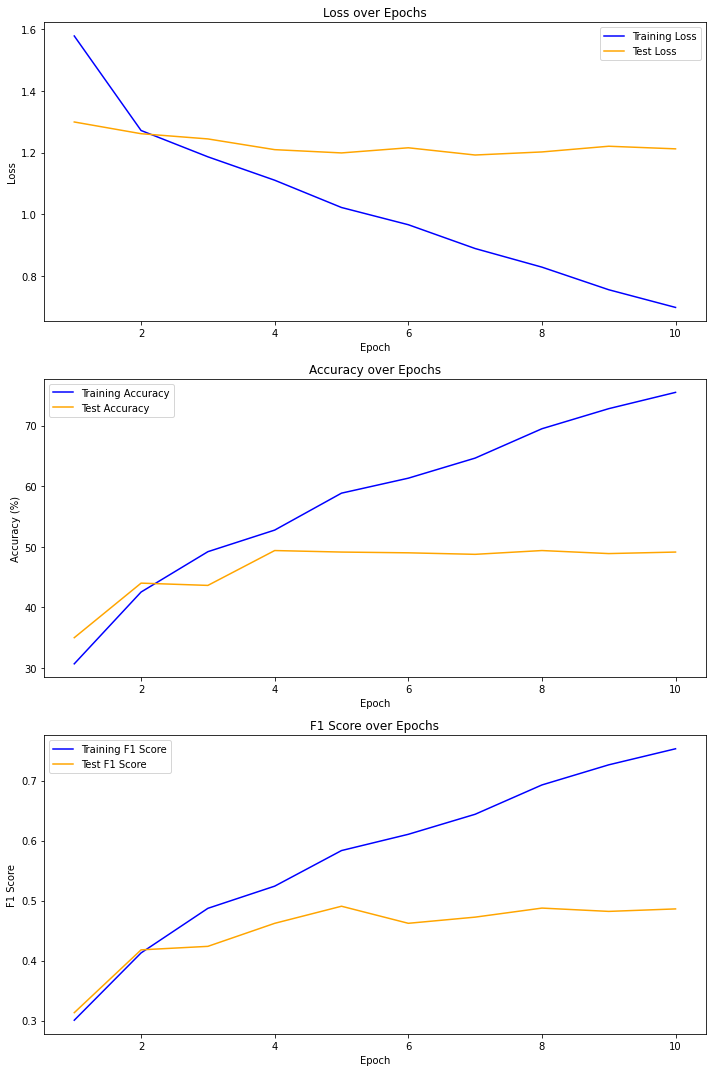

In [ ]:
def plot_metric(train_data, test_data, metric_name, num_epochs, subplot_index, title, ylabel):
    plt.subplot(3, 1, subplot_index)
    plt.plot(range(1, num_epochs + 1), train_data, label='Training ' + metric_name, color='blue')
    plt.plot(range(1, num_epochs + 1), test_data, label='Test ' + metric_name, color='orange')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()

# Построение графиков
plt.figure(figsize=(10, 15))

# Графики функции потерь
plot_metric(train_loss_list, test_loss_list, 'Loss', num_epochs, 1, 'Loss over Epochs', 'Loss')

# Графики точности
plot_metric(train_accuracy_list, test_accuracy_list, 'Accuracy', num_epochs, 2, 'Accuracy over Epochs', 'Accuracy (%)')

# Графики F1 Score
plot_metric(train_f1_list, test_f1_list, 'F1 Score', num_epochs, 3, 'F1 Score over Epochs', 'F1 Score')

plt.tight_layout()
plt.show()

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()

        # Определение слоев
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2)  # CONV1
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)  # MAX POOL1
        self.norm1 = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75)  # NORM1

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, padding=2)  # CONV2
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)  # MAX POOL2
        self.norm2 = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75)  # NORM2

        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1)  # CONV3
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)  # CONV4
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # CONV5
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)  # MAX POOL3

        self.fc6 = nn.Linear(256 * 8 * 8, 4096)  # FC6
        self.fc7 = nn.Linear(4096, 4096)  # FC7
        self.fc8 = nn.Linear(4096, num_classes)  # FC8

    def forward(self, x):
        # Прямое распространение
        x = self.pool1(self.norm1(F.relu(self.conv1(x))))  # CONV1 -> NORM1 -> MAX POOL1
        x = self.pool2(self.norm2(F.relu(self.conv2(x))))  # CONV2 -> NORM2 -> MAX POOL2
        x = F.relu(self.conv3(x))  # CONV3
        x = F.relu(self.conv4(x))  # CONV4
        x = F.relu(self.conv5(x))  # CONV5
        x = self.pool3(x)  # MAX POOL3

        x = x.view(x.size(0), -1)  # Преобразование в вектор
        x = F.relu(self.fc6(x))  # FC6
        x = F.relu(self.fc7(x))  # FC7
        x = self.fc8(x)  # FC8

        return x

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.dataset.classes)

# Создание  модели
model = AlexNet(num_classes=num_classes)
print(f'Количество параметров модели: {sum(p.numel() for p in model.parameters())}')

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Обучение модели
num_epochs = 15
train_loss_list, train_accuracy_list, train_f1_list, test_loss_list, test_accuracy_list, test_f1_list  = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs)

Количество параметров модели: 86380356


  5%|▌         | 1/20 [00:28<09:09, 28.92s/it]

Epoch [1/20]:
  Train Loss: 1.3347, Train Accuracy: 32.84%, Train F1 Score: 0.32
  Test Loss: 1.2787, Test Accuracy: 38.75%, Test F1 Score: 0.32


 10%|█         | 2/20 [00:57<08:33, 28.53s/it]

Epoch [2/20]:
  Train Loss: 1.2184, Train Accuracy: 44.72%, Train F1 Score: 0.43
  Test Loss: 1.1766, Test Accuracy: 49.50%, Test F1 Score: 0.50


 15%|█▌        | 3/20 [01:26<08:12, 29.00s/it]

Epoch [3/20]:
  Train Loss: 1.1545, Train Accuracy: 49.41%, Train F1 Score: 0.48
  Test Loss: 1.1337, Test Accuracy: 53.00%, Test F1 Score: 0.52


 20%|██        | 4/20 [01:55<07:41, 28.83s/it]

Epoch [4/20]:
  Train Loss: 1.1261, Train Accuracy: 51.50%, Train F1 Score: 0.50
  Test Loss: 1.1080, Test Accuracy: 54.00%, Test F1 Score: 0.53


 25%|██▌       | 5/20 [02:25<07:22, 29.47s/it]

Epoch [5/20]:
  Train Loss: 1.0530, Train Accuracy: 55.53%, Train F1 Score: 0.55
  Test Loss: 1.0942, Test Accuracy: 54.75%, Test F1 Score: 0.51


 30%|███       | 6/20 [02:56<06:59, 29.93s/it]

Epoch [6/20]:
  Train Loss: 0.9999, Train Accuracy: 57.66%, Train F1 Score: 0.57
  Test Loss: 1.0672, Test Accuracy: 55.37%, Test F1 Score: 0.55


 35%|███▌      | 7/20 [03:26<06:29, 29.96s/it]

Epoch [7/20]:
  Train Loss: 0.9329, Train Accuracy: 61.53%, Train F1 Score: 0.61
  Test Loss: 1.0715, Test Accuracy: 55.12%, Test F1 Score: 0.50


 40%|████      | 8/20 [03:56<05:59, 29.98s/it]

Epoch [8/20]:
  Train Loss: 0.8542, Train Accuracy: 64.81%, Train F1 Score: 0.64
  Test Loss: 1.0076, Test Accuracy: 58.25%, Test F1 Score: 0.58


 45%|████▌     | 9/20 [04:27<05:32, 30.20s/it]

Epoch [9/20]:
  Train Loss: 0.7736, Train Accuracy: 67.97%, Train F1 Score: 0.67
  Test Loss: 1.1057, Test Accuracy: 57.00%, Test F1 Score: 0.56


 50%|█████     | 10/20 [04:58<05:05, 30.52s/it]

Epoch [10/20]:
  Train Loss: 0.7023, Train Accuracy: 71.25%, Train F1 Score: 0.71
  Test Loss: 1.0416, Test Accuracy: 60.37%, Test F1 Score: 0.59


 55%|█████▌    | 11/20 [05:29<04:34, 30.53s/it]

Epoch [11/20]:
  Train Loss: 0.5907, Train Accuracy: 76.09%, Train F1 Score: 0.76
  Test Loss: 1.1176, Test Accuracy: 58.25%, Test F1 Score: 0.58


 60%|██████    | 12/20 [05:59<04:04, 30.50s/it]

Epoch [12/20]:
  Train Loss: 0.4552, Train Accuracy: 81.66%, Train F1 Score: 0.81
  Test Loss: 1.4891, Test Accuracy: 56.12%, Test F1 Score: 0.55


 65%|██████▌   | 13/20 [06:30<03:33, 30.49s/it]

Epoch [13/20]:
  Train Loss: 0.3406, Train Accuracy: 87.06%, Train F1 Score: 0.87
  Test Loss: 1.5574, Test Accuracy: 56.63%, Test F1 Score: 0.56


 70%|███████   | 14/20 [07:00<03:03, 30.56s/it]

Epoch [14/20]:
  Train Loss: 0.2565, Train Accuracy: 90.22%, Train F1 Score: 0.90
  Test Loss: 1.7196, Test Accuracy: 56.12%, Test F1 Score: 0.56


 75%|███████▌  | 15/20 [07:30<02:32, 30.41s/it]

Epoch [15/20]:
  Train Loss: 0.1529, Train Accuracy: 94.94%, Train F1 Score: 0.95
  Test Loss: 1.9940, Test Accuracy: 55.62%, Test F1 Score: 0.55


 80%|████████  | 16/20 [08:00<02:00, 30.08s/it]

Epoch [16/20]:
  Train Loss: 0.1245, Train Accuracy: 95.59%, Train F1 Score: 0.96
  Test Loss: 1.9686, Test Accuracy: 53.37%, Test F1 Score: 0.53


 85%|████████▌ | 17/20 [08:29<01:29, 29.93s/it]

Epoch [17/20]:
  Train Loss: 0.0713, Train Accuracy: 97.94%, Train F1 Score: 0.98
  Test Loss: 2.3999, Test Accuracy: 57.25%, Test F1 Score: 0.57


 90%|█████████ | 18/20 [09:00<00:59, 30.00s/it]

Epoch [18/20]:
  Train Loss: 0.0483, Train Accuracy: 98.62%, Train F1 Score: 0.99
  Test Loss: 2.6363, Test Accuracy: 55.87%, Test F1 Score: 0.56


 95%|█████████▌| 19/20 [09:29<00:29, 29.96s/it]

Epoch [19/20]:
  Train Loss: 0.0068, Train Accuracy: 99.91%, Train F1 Score: 1.00
  Test Loss: 3.2117, Test Accuracy: 57.63%, Test F1 Score: 0.57


100%|██████████| 20/20 [09:58<00:00, 29.95s/it]

Epoch [20/20]:
  Train Loss: 0.0013, Train Accuracy: 100.00%, Train F1 Score: 1.00
  Test Loss: 3.3469, Test Accuracy: 58.63%, Test F1 Score: 0.59


In [ ]:
# Оценка модели на тестовом множестве
_, test_accuracy, test_f1 = evaluate_model(model, test_loader, criterion)

In [ ]:
print(f'accuracy на обучающем множестве: {train_accuracy_list[-1]:.2f}%')
print(f'F1 score на обучающем множестве: {train_f1_list[-1]:.2f}')
print(f'accuracy на тестовом множестве: {test_accuracy:.2f}%')
print(f'F1 score на тестовом множестве: {test_f1:.2f}')

accuracy на обучающем множестве: 100.00%
F1 score на обучающем множестве: 1.00
accuracy на тестовом множестве: 58.63%
F1 score на тестовом множестве: 0.59


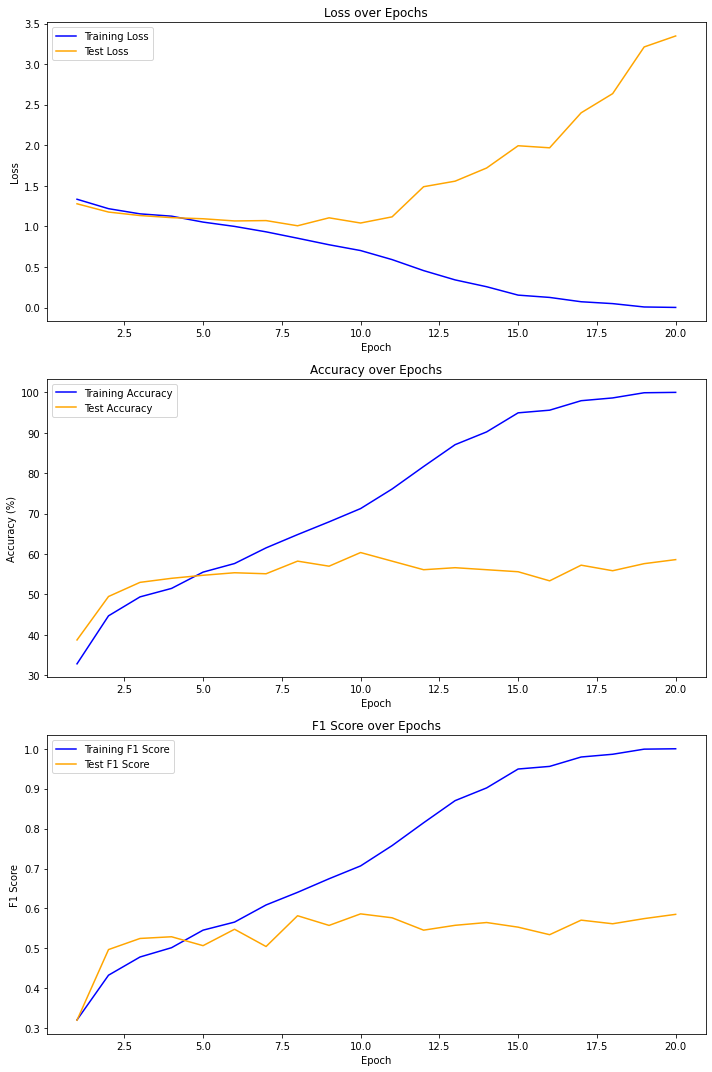

In [ ]:
def plot_metric(train_data, test_data, metric_name, num_epochs, subplot_index, title, ylabel):
    plt.subplot(3, 1, subplot_index)
    plt.plot(range(1, num_epochs + 1), train_data, label='Training ' + metric_name, color='blue')
    plt.plot(range(1, num_epochs + 1), test_data, label='Test ' + metric_name, color='orange')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()

# Построение графиков
plt.figure(figsize=(10, 15))

# Графики функции потерь
plot_metric(train_loss_list, test_loss_list, 'Loss', num_epochs, 1, 'Loss over Epochs', 'Loss')

# Графики точности
plot_metric(train_accuracy_list, test_accuracy_list, 'Accuracy', num_epochs, 2, 'Accuracy over Epochs', 'Accuracy (%)')

# Графики F1 Score
plot_metric(train_f1_list, test_f1_list, 'F1 Score', num_epochs, 3, 'F1 Score over Epochs', 'F1 Score')

plt.tight_layout()
plt.show()

<p class="task" id="5"></p>

5\. Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.


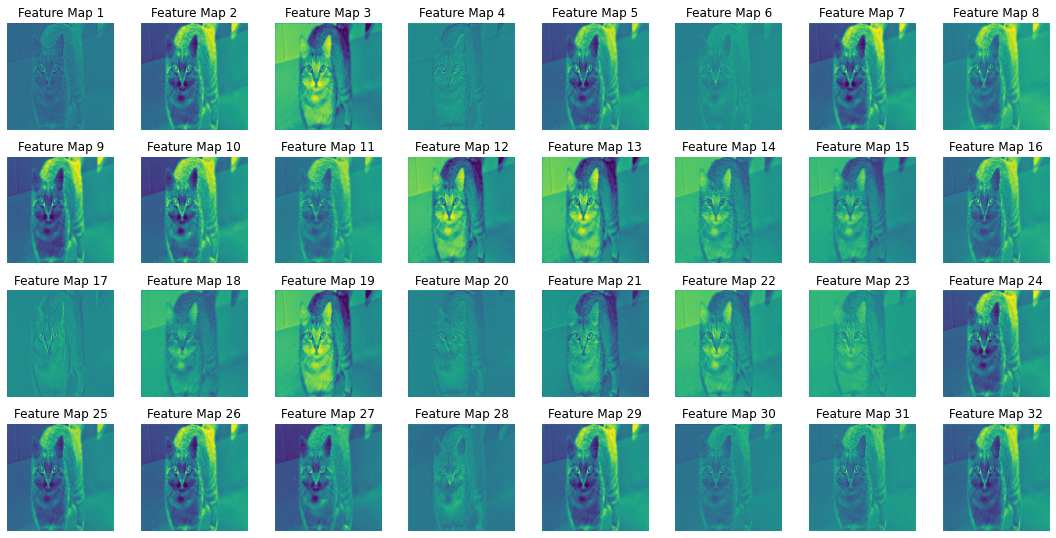

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_feature_maps(model, dataset, index):
    model.eval()  # Устанавливаем модель в режим оценки

    # Получаем изображение и метку из тестового набора
    image, label = dataset[index]

    # Преобразуем изображение в нужный формат
    image = image.unsqueeze(0)  # Добавляем размерность батча
    #image = image.to('cuda')  # Перемещаем на GPU, если используем

    # Пропускаем изображение через первый свёрточный слой
    with torch.no_grad():
        feature_maps = model.conv1(image)  # Получаем карты признаков

    # Визуализация карт признаков
    num_feature_maps = feature_maps.size(1)  # Количество карт признаков
    plt.figure(figsize=(15, 15))

    for i in range(num_feature_maps):
        plt.subplot(8, 8, i + 1)  # Строим подграфики
        plt.imshow(feature_maps[0, i].cpu(), cmap='viridis')  # Визуализация карты признаков
        plt.axis('off')  # Отключаем оси
        plt.title(f'Feature Map {i + 1}')

    plt.tight_layout()
    plt.show()

# Использование функции для визуализации карт признаков
index = 1  # Выберите индекс изображения из тестового набора
visualize_feature_maps(model, test_dataset.dataset, index)


## Обратная связь
- [ ] Хочу получить обратную связь по решению